In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
import matplotlib.animation
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd

import pims
import trackpy as tp
from PIL import Image, ImageDraw
import cv2

#import numba
import timeit

import random

import trackpy.diag
tp.quiet()

In [2]:
@pims.pipeline
def crop(image, x1, y1, x2, y2):
    npImage = np.array(image)
    
    # Create same size alpha layer with circle
    alpha = Image.new('L', (720, 720), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:,:,1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[150, 150] color of the border to swap with the black
    npImage[ind] = npImage[150, 150]
    return npImage

@pims.pipeline
def crop2(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

# Main trial

In [5]:
frames = crop2(pims.open('/Volumes/ExtremeSSD/UNI/thesis/ThesisData/data_video/movie.mp4'), 55, 55, 880, 880)
print(frames)
ref = pims.open('/Volumes/ExtremeSSD/UNI/thesis/ThesisData/data_video/movie.mp4')


deprecated pixel format used, make sure you did set range correctly


(PyAVReaderTimed,) processed through proc_func. Original repr:
    <Frames>
    Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
    Source: /Volumes/ExtremeSSD/UNI/thesis/ThesisData/data_video/movie.mp4
    Duration: 8079.400 seconds
    Frame rate: 10.000 fps
    Length: 80794 frames
    Frame Shape: (960, 920, 3)
    


deprecated pixel format used, make sure you did set range correctly


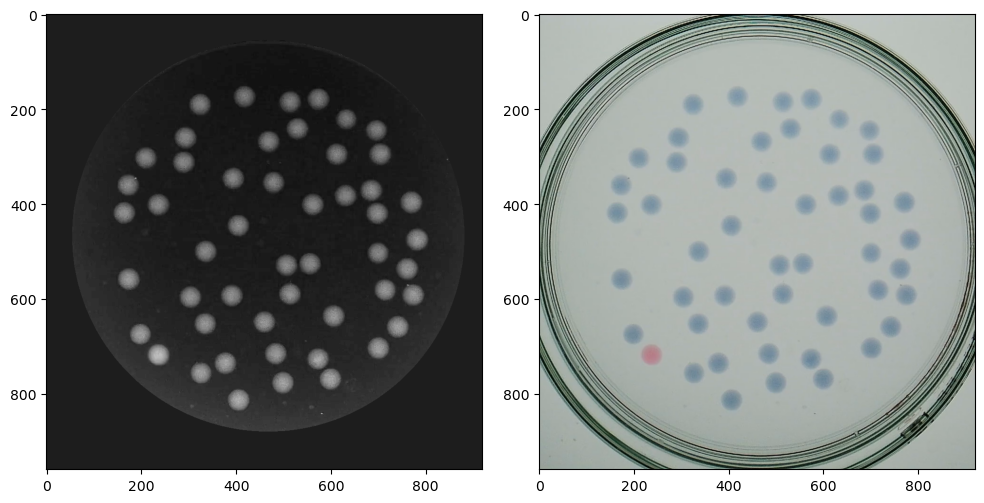

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frames[0])
ax2.imshow(ref[0])
plt.tight_layout()
plt.show()

In [7]:
dropSize = 31 #yranges of a drop 335-307 #xranges of a drop 118-90 --> 28 but needs to be odd so 29
minMass = 2000
sep = 16
nDrops = 50

In [8]:
preMerge = frames[32268]
merge = frames[32269]
postMerge = frames[32270]

deprecated pixel format used, make sure you did set range correctly


KeyboardInterrupt: 

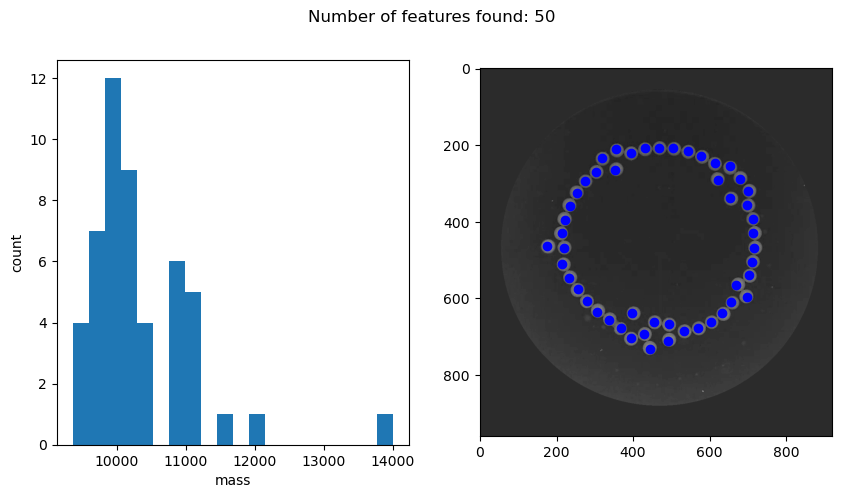

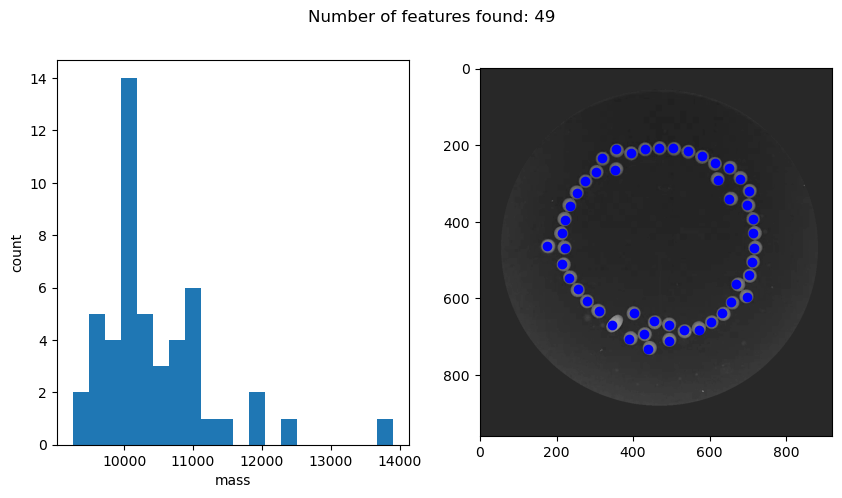

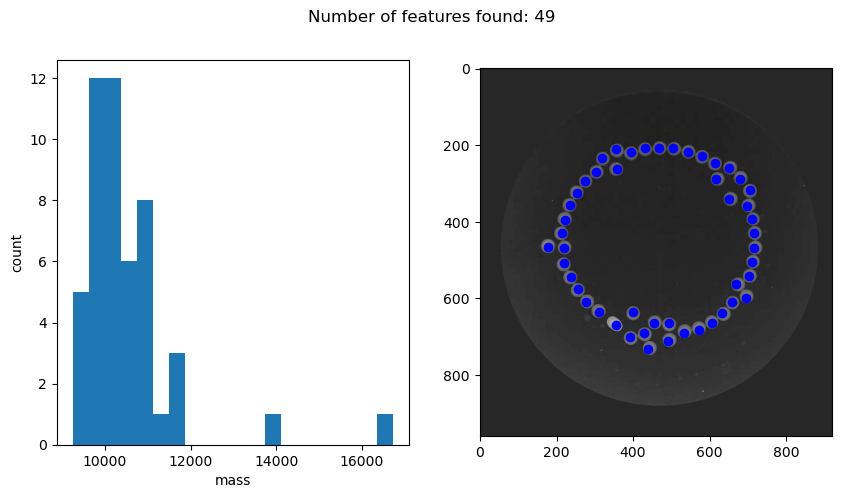

In [10]:
# feature location with minMass, have some problems but the spurious effect are solved
f = tp.locate(preMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(preMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")
plt.show()

f = tp.locate(merge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(merge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

f = tp.locate(postMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(postMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")


plt.show()

In [ ]:
tp.subpx_bias(f)
plt.show()

# Tracking routine

# TRACKING UP TO MERGING --> FRAME 32268

In [ ]:
if 0:
    start = timeit.default_timer()
    preMergeFrame = 32268
    f1 = tp.batch(frames[:preMergeFrame], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')
    end = timeit.default_timer()
    print(end-start)

In [9]:
if 1:
    start = timeit.default_timer()
    startFrame = 32270
    nFrames = startFrame + 100 #80700

    f2 = tp.batch(frames[startFrame:nFrames], dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
    end = timeit.default_timer()
    print(end-start)

deprecated pixel format used, make sure you did set range correctly
 (repeated 25742 more times)
deprecated pixel format used, make sure you did set range correctly


268.1835105650098


In [13]:
num = np.zeros(nFrames)
for i in range(nFrames):
    num[i] = len(f.loc[f['frame'] == i])
    
idx = np.where(num != nDrops)[0]
print(idx)
if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

[    0     3     5 ... 32367 32368 32369]
[3. 2. 1. ... 1. 1. 1.]


In [14]:
#documentation --> tp.link?
t = tp.link_df(f, 150, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)

num = np.zeros(nFrames)
for i in range(nFrames):
    num[i] = len(t.loc[t['frame'] == i])
    
idx = np.where(num != nDrops)[0]
if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]

In [15]:
t

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,208.129967,430.461182,9877.717991,10.080059,0.033272,20.398782,80942.0,0.001830,0,0
27,508.147195,218.499015,10807.992124,10.322376,0.060465,21.743757,85550.0,0.001564,0,1
28,504.711883,709.441486,10171.146627,10.379287,0.069806,20.174620,84800.0,0.001602,0,2
29,540.330890,703.725879,10396.878206,10.472569,0.084819,20.622945,86820.0,0.001504,0,3
30,544.196033,236.768571,10272.019726,10.496262,0.068657,20.622945,86488.0,0.001519,0,4
...,...,...,...,...,...,...,...,...,...,...
4901,352.620521,230.569552,9425.342613,10.352715,0.098331,19.953782,82936.0,0.001721,99,44
4902,384.437324,209.166645,9858.903602,10.247672,0.043541,21.038227,84120.0,0.001653,99,47
4903,393.797703,716.778179,9498.000407,10.142224,0.071333,18.435560,81484.0,0.001811,99,46
4892,257.221492,654.385712,10531.476201,10.505674,0.051236,21.038227,82022.0,0.001777,99,36


In [ ]:
np.where(t.particle.iloc[:30000,"particle"]!=49

In [ ]:
n = max(t.particle)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c
t.to_csv(f'/Users/matteoscandola/thesisData/Processed_data.csv', index=False)

In [ ]:
t = pd.read_csv("/Users/matteoscandola/thesisData/Processed_data.csv")

In [ ]:
nFrames = max(t.frame)

In [ ]:
lost_particles = []
for i in range(nFrames-1):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])

print("Total problems:",len(lost_particles))
if len(lost_particles)>0: 
    print(f"first problem at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

In [ ]:
f1

In [ ]:
if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(frames[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(frames[f2])

    plt.show()

In [ ]:
t1 = tp.filter_stubs(t, 80000)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:
plt.figure()
tp.plot_traj(t1)
plt.show()

In [ ]:
plt.figure()
plt.title(f"1: {len(t1[t1['particle'] == 0].x)}")
plt.plot(t1[t1['particle'] == 0].x, t1[t1['particle'] == 0].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 1].x, t1[t1['particle'] == 1].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 2].x, t1[t1['particle'] == 2].y, linewidth=.1)
plt.show()

# trial with different drop colors

In [ ]:
blue_frames = red(pims.open('/Users/matteoscandola/thesisData/Movie36.mp4'))

dropSize = 31 #yranges of a drop 335-307 #xranges of a drop 118-90 --> 28 but needs to be odd so 29
loc = tp.locate(blue_frames[0], 31, invert = True, minmass = 10000, separation = 16, topn = 59, engine = 'numba')
    
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(loc['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')

ax2.imshow(blue_frames[0])
ax2.plot(loc.x, loc.y, 'bo')

plt.suptitle(f"Number of features found: {len(loc)}")
plt.tight_layout()
#plt.savefig(f"imgs/mM{minMass}_dS{dropSize}_s{sep}_f{frame}.png")
plt.show()